In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pandas as pd
import gridmeter as gm

import matplotlib as mpl
import matplotlib.pyplot as plt

from timeit import default_timer as timer

In [15]:
# Load and assign data

# data_type = "month_loadshape"
# data_type = "seasonal_day_of_week_loadshape"
data_type = "seasonal_hourly_day_of_week_loadshape"

df_ls_all = gm.load_tutorial_data(data_type)

# randomly select 100 ids from df_ls_all
all_ids = df_ls_all.index.to_list()
t_ids = np.random.choice(all_ids, 100, replace=False)

df_ls_treatment = df_ls_all.loc[t_ids]

# remove t_ids from all_ids
all_ids = [x for x in all_ids if x not in t_ids]
cp_ids = np.random.choice(all_ids, 1000, replace=False)

df_ls_pool = df_ls_all.loc[cp_ids]

In [16]:
# Set data classes

pool_data = gm.Data(loadshape_df=df_ls_pool)
treatment_data = gm.Data(loadshape_df=df_ls_treatment)

In [17]:
n_matches_per_treatment = 4
distance_metric = "euclidean"
allow_duplicates = False
max_distance_threshold = None
n_meters_per_chunk = 10000

t_df = treatment_data.loadshape
cp_df = pool_data.loadshape

/app/applied_data_science/gridmeter/gridmeter/gridmeter/individual_meter_matching/distance_calc_selection.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


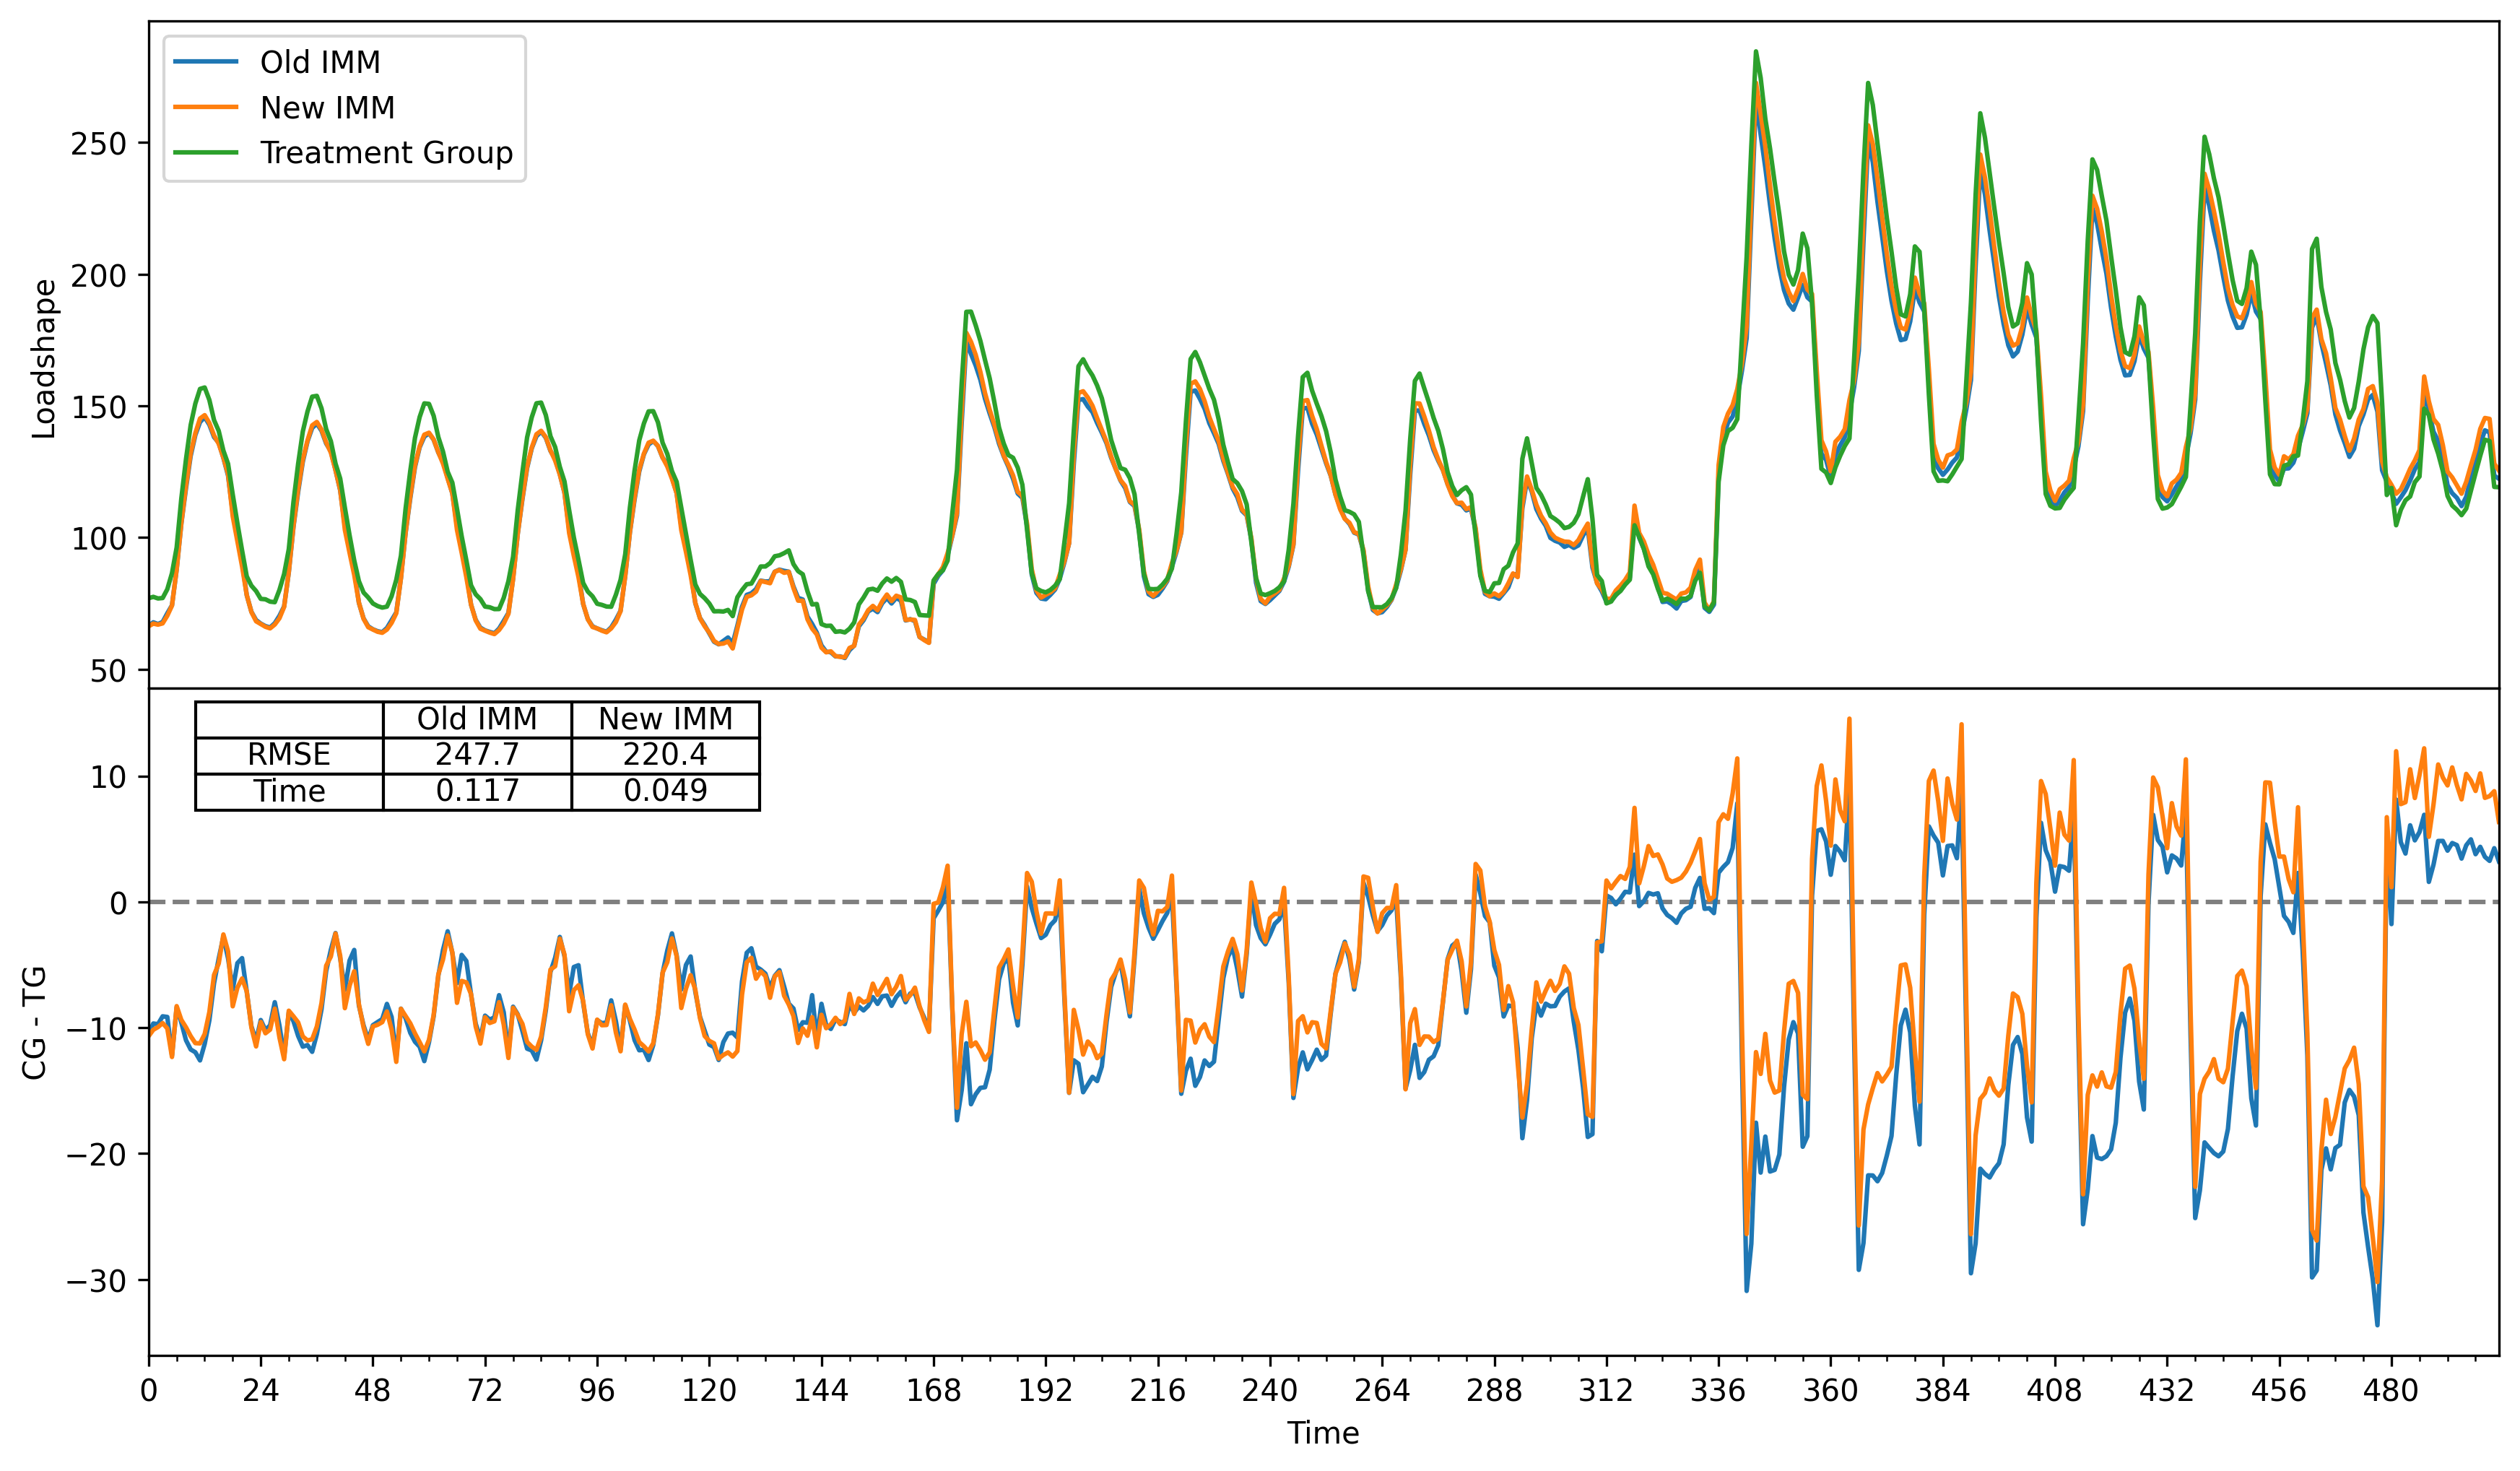

In [18]:
# OLD IMM
imm_settings = gm.Old_IMM_Settings()
imm_old = gm.Old_IMM(imm_settings)
pool_data = gm.Data(loadshape_df=df_ls_pool)
treatment_data = gm.Data(loadshape_df=df_ls_treatment)
start = timer()
df_cg_old, df_t_coeffs_old = imm_old.get_comparison_group(treatment_data, pool_data)
old_time = timer() - start

ls_old = imm_old.get_loadshapes()

# NEW IMM
imm_settings = gm.IMM_Settings(DISTANCE_METRIC="euclidean", ALLOW_DUPLICATE_MATCHES=False)
# imm_settings = gm.IMM_Settings(DISTANCE_METRIC="manhattan", ALLOW_DUPLICATE_MATCHES=False)
imm_new = gm.IMM(imm_settings)
pool_data = gm.Data(loadshape_df=df_ls_pool)
treatment_data = gm.Data(loadshape_df=df_ls_treatment)
start = timer()
df_cg, df_t_coeffs = imm_new.get_comparison_group(treatment_data, pool_data)
new_time = timer() - start

ls_new = imm_new.get_loadshapes()

# compute rmse of ls_new old and new "treatment_group vs. comparison_group"
old_rmse = (np.sum((ls_old.loc["Comparison Group"] - ls_old.loc["Treatment Group"])**2))**0.5
new_rmse = (np.sum((ls_new.loc["Comparison Group"] - ls_new.loc["Treatment Group"])**2))**0.5

# plot treatment group in ls_old and all of ls_new using matplotlib in one figure
t_min = ls_new.T.index[0]
t_max = ls_new.T.index[-1]

# plot ls
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), dpi=300)
plt.subplots_adjust(hspace=0)

ax1.plot(ls_old.T.index, ls_old.T["Comparison Group"], label="Old IMM")
ax1.plot(ls_new.T.index, ls_new.T["Comparison Group"], label="New IMM")
ax1.plot(ls_new.T.index, ls_new.T["Treatment Group"], label="Treatment Group")
# ax1.plot(ls_new.T.index, ls_new.T["Comparison Pool"], label="Comparison Pool", color="black", alpha=0.5)

ax1.set_xticks([])
ax1.set_ylabel('Loadshape')
ax1.legend()

# make ax2 plot the difference between the two loadshapes
ax2.axhline(0, linestyle="--", color="black", alpha=0.5)
ax2.plot(ls_new.T.index, ls_old.T["Comparison Group"] - ls_old.T["Treatment Group"], label="Old IMM")
ax2.plot(ls_new.T.index, ls_new.T["Comparison Group"] - ls_new.T["Treatment Group"], label="New IMM")

if (t_max - t_min) % 24 and (t_max - t_min) > 24:
    ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax2.set_xticks(np.arange(t_min, t_max, 24))

ax2.set_xlabel('Time')
ax2.set_ylabel('CG - TG')

ax1.set_xlim([t_min, t_max])
ax2.set_xlim([t_min, t_max])

# add RMSE to plot next to legend
# get y limits of ax2
y_min, y_max = ax2.get_ylim()
x_txt = (t_max-t_min)/2
y_txt = (y_max - y_min) * 0.9 + y_min

# plot table of RMSE and time using latex
table_data = [["RMSE", round(old_rmse, 1), round(new_rmse, 1)], ["Time", round(old_time, 3), round(new_time, 3)]]
width = 0.08
table = ax2.table(cellText=table_data, colLabels=["", "Old IMM", "New IMM"], cellLoc="center", loc=2, colWidths=[width]*3, zorder=99)

fig.show()